<a href="https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GREMLIN_TF v2
GREMLIN implemented in tensorflow

### Change log:
*   16Jan2018
 - updating how indices are handled (for easier/cleaner parsing)
 - minor speed up in how we symmetrize and zero the diagional of W
 - added a simplified version of the GREMLIN algorithm/model for educational purposes! (see very bottom of notebook)
*   15Jan2018
 - LBFGS optimizer replaced with a modified version of the ADAM optimizer
 - Added option for stochastic gradient descent (via batch_size)
  
### Method:
GREMLIN takes a multiple sequence alignment (MSA) and returns a Markov Random Field (MRF or Potts model). The MRF consists of a one-body term (V) that encodes conservation, and a two-body term (W) that encodes co-evolution.

For more details about the method see:
[Google slides](https://docs.google.com/presentation/d/1aooxoksosSv7CWs9-ktqhUjyXR3wrgbG5a6PCr92od4/) and [Google colab](https://colab.research.google.com/drive/17RJcExuyifnd7ShTcsZGh6mBpWq0-s60)


In [0]:
# ------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42):
# <so@g.harvard.edu> and <pkk382@g.harvard.edu> wrote this code.
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy us a beer in return.
# --Sergey Ovchinnikov and Peter Koo
# ------------------------------------------------------------
#
# if you use this code, please cite the following papers:
#
# Balakrishnan, Sivaraman, Hetunandan Kamisetty, Jaime G. Carbonell,
# Su‐In Lee, and Christopher James Langmead.
# "Learning generative models for protein fold families."
# Proteins: Structure, Function, and Bioinformatics 79, no. 4 (2011): 1061-1078.
#
# Kamisetty, Hetunandan, Sergey Ovchinnikov, and David Baker.
# "Assessing the utility of coevolution-based residue–residue
# contact predictions in a sequence-and structure-rich era."
# Proceedings of the National Academy of Sciences (2013): 201314045.

## libraries

In [0]:
# IMPORTANT, only tested using PYTHON 3!
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from scipy import stats
from scipy.spatial.distance import pdist,squareform
import pandas as pd

## Params

In [0]:
################
# note: if you are modifying the alphabet
# make sure last character is "-" (gap)
################
alphabet = "ARNDCQEGHILKMFPSTWYV-"
states = len(alphabet)
a2n = {}
for a,n in zip(alphabet,range(states)):
  a2n[a] = n
################

def aa2num(aa):
  '''convert aa into num'''
  if aa in a2n: return a2n[aa]
  else: return a2n['-']

## Functions for working prepping MSA (Multiple sequence alignment)

In [0]:
# from fasta
def parse_fasta(filename,limit=-1):
  '''function to parse fasta'''
  header = []
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      if len(header) == limit:
        break
      header.append(line[1:])
      sequence.append([])
    else:
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return np.array(header), np.array(sequence)

def filt_gaps(msa,gap_cutoff=0.5):
  '''filters alignment to remove gappy positions'''
  tmp = np.zeros_like(msa)
  tmp[np.where(msa == 20)] = 1
  non_gaps = np.where(np.sum(tmp.T,-1).T/msa.shape[0] < gap_cutoff)[0]
  return msa[:,non_gaps],non_gaps

def get_eff(msa,eff_cutoff=0.8):
  '''compute effective weight for each sequence'''
  length = msa.shape[1]
  
  # pairwise identity
  msa_sm = 1.0 - squareform(pdist(msa,"hamming"))

  # weight for each sequence
  msa_w = np.zeros_like(msa_sm)
  msa_w[np.where(msa_sm >= eff_cutoff)] = 1
  msa_w = 1/np.sum(msa_w,-1)
  
  return msa_w

def mk_msa(seqs):
  '''converts list of sequences to msa'''
  
  msa_ori = []
  for seq in seqs:
    msa_ori.append([aa2num(aa) for aa in seq])
  msa_ori = np.array(msa_ori)
  
  # remove positions with more than > 50% gaps
  msa, v_idx = filt_gaps(msa_ori,0.5)
  
  # compute effective weight for each sequence
  msa_weights = get_eff(msa,0.8)

  # compute effective number of sequences
  length = msa.shape[1] # length of sequence
  w_idx = v_idx[np.stack(np.triu_indices(length,1),-1)]
  
  return {"msa_ori":msa_ori,
          "msa":msa,
          "msa_weights":msa_weights,
          "neff":np.sum(msa_weights),
          "v_idx":v_idx,
          "w_idx":w_idx,
          "num":msa.shape[0],
          "length":length,
          "length_ori":msa_ori.shape[1]}


## Optimizers

In [0]:
########################################################################################
# ADAM
########################################################################################
# Note: this is a modified version of adam optimizer. More specifically, we replace "vt"
# with sum(g*g) instead of (g*g). Furthmore, we find that disabling the bias correction
# (b_fix=False) speeds up convergence for our case.
########################################################################################
def opt_adam(loss, var_list=None, lr=1.0, scope="adam", b1=0.9, b2=0.999, b_fix=False):
  if var_list is None: var_list = tf.trainable_variables()  
  with tf.variable_scope(scope):
    gradients = tf.gradients(xs=var_list,ys=loss)
    if b_fix: t = tf.Variable(1.0,"t")
    opt = []
    for n,(x,g) in enumerate(zip(var_list,gradients)):
      if g is not None:
        ini = dict(initializer=tf.zeros_initializer,trainable=False)
        mt = tf.get_variable("mt_"+str(n),shape=x.shape, **ini)
        vt = tf.get_variable("vt_"+str(n),shape=(1,), **ini)
        mt_tmp = b1*mt+(1-b1)*g
        vt_tmp = b2*vt+(1-b2)*tf.reduce_sum(tf.square(g))
        lr_tmp = lr/tf.sqrt(vt_tmp)
        
        if b_fix: lr_tmp = lr_tmp * tf.sqrt(1-tf.pow(b2,t))/(1-tf.pow(b1,t))
        
        opt.append(x.assign_add(-lr_tmp * mt_tmp))
        opt.append(vt.assign(vt_tmp))
        opt.append(mt.assign(mt_tmp))
        
    if b_fix: t.assign_add(1.0)
    return(tf.group(opt))
  
########################################################################################
# SGD
########################################################################################
# for comparison we also implement a simple gradient decent optimizer
# note: opt_sgd() == opt_adam(b1=0.0, b2=0.0, b_fix=False)
########################################################################################
def opt_sgd(loss, var_list=None, lr=1.0):
  if var_list is None: var_list = tf.trainable_variables()  
  gradients = tf.gradients(xs=var_list,ys=loss)
  opt = []
  for x,g in zip(var_list,gradients):
    if g is not None:
      lr_tmp = lr/tf.sqrt(tf.reduce_sum(tf.square(g)))
      opt.append(x.assign_add(-lr_tmp * g))
  return(tf.group(opt))

## GREMLIN

In [0]:
def GREMLIN(msa, opt_type="adam", opt_iter=200, opt_rate=1.0, batch_size=None):
  
  ##############################################################
  # SETUP COMPUTE GRAPH
  ##############################################################
  # kill any existing tensorflow graph
  tf.reset_default_graph()
  
  length = msa["length"] # length of sequence

  # msa (multiple sequence alignment) 
  MSA = tf.placeholder(tf.int32,shape=(None,length),name="msa")
  
  # one-hot encode msa
  OH_MSA = tf.one_hot(MSA,states)
  
  # msa weights
  MSA_weights = tf.placeholder(tf.float32, shape=(None,), name="msa_weights")
  
  # compute frequencies
  F = tf.keras.utils.to_categorical(msa["msa"],states)
  F = tf.constant(np.sum(F.T*msa["msa_weights"],-1).T,tf.float32)
  
  # 1-body-term of the MRF
  V = tf.get_variable(name="V", 
                      shape=[length,states],
                      dtype=tf.float32, 
                      initializer=tf.zeros_initializer)

  # 2-body-term of the MRF
  W_tmp = tf.get_variable(name="W_tmp",
                          shape=[length,states,length,states],
                          dtype=tf.float32,
                          initializer=tf.zeros_initializer)
  
  # set diagional to zero and symmetrize
  W = W_tmp * np.reshape(1-np.eye(length),(length,1,length,1))
  W = 0.5 * (W + tf.transpose(W,[2,3,0,1]))
  
  def L2(x): return tf.reduce_sum(tf.square(x))
  
  ########################################
  # V
  ########################################
  # Note: we find optimizing V first, requires
  # less steps for V+W convergence
  loss_V = -tf.reduce_sum(F * tf.log(tf.nn.softmax(V,axis=-1)))
  loss_V = loss_V + 0.01*L2(V)
    
  ########################################
  # V + W
  ########################################
  VW = V + tf.tensordot(OH_MSA,W,2)

  # hamiltonian
  H = tf.reduce_sum(tf.multiply(OH_MSA,VW),axis=2)
  # local Z (parition function)
  Z = tf.reduce_logsumexp(VW,axis=2)

  # Psuedo-Log-Likelihood
  PLL = tf.reduce_sum(H - Z, axis=1)

  # Regularization
  L2_V = 0.01 * L2(V)
  L2_W = 0.01 * L2(W) * 0.5 * tf.constant((length-1)*(states-1),tf.float32)

  # loss function to minimize
  loss_VW = -tf.reduce_sum(PLL*MSA_weights)
  if batch_size is not None:
    loss_VW = loss_VW * (msa["neff"]/tf.reduce_sum(MSA_weights))
  loss_VW = loss_VW + L2_V + L2_W

  ##############################################################
  # MINIMIZE LOSS FUNCTION
  ##############################################################
  if opt_type == "adam":  
    opt_V = opt_adam(loss_V,var_list=[V],lr=opt_rate,scope="V")
    opt_VW = opt_adam(loss_VW,var_list=[V,W_tmp],lr=opt_rate,scope="VW")
    
  if opt_type == "sgd":  
    opt_V = opt_sgd(loss_V,var_list=[V],lr=opt_rate)
    opt_VW = opt_sgd(loss_VW,var_list=[V,W_tmp],lr=opt_rate)

  with tf.Session() as sess:
    # initialize variables V and W
    sess.run(tf.global_variables_initializer())
    if opt_type == "lbfgs":
      lbfgs = tf.contrib.opt.ScipyOptimizerInterface
      # optimize V
      opt = lbfgs(loss_V,method="L-BFGS-B",options={'maxiter': opt_iter},var_list=[V])
      opt.minimize(sess)
      
      # optimize V+W
      opt = lbfgs(loss_VW,method="L-BFGS-B",options={'maxiter': opt_iter},var_list=[V,W_tmp])
      opt.minimize(sess,{MSA:msa["msa"],MSA_weights:msa["msa_weights"]})
      
    # input to placeholders
    feed = {MSA:msa["msa"],MSA_weights:msa["msa_weights"]}
    if opt_type == "adam" or opt_type == "sgd":
      
      for i in range(opt_iter): sess.run(opt_V)
      print("loss_V",sess.run(loss_V))
      
      for i in range(opt_iter):
        if batch_size is None: sess.run(opt_VW,feed)
        else:
          idx = np.random.randint(0,msa["num"],size=batch_size)
          sess.run(opt_VW,{MSA:msa["msa"][idx],MSA_weights:msa["msa_weights"][idx]})
          
        if (i+1) % int(opt_iter/10) == 0:
          print("loss_VW",(i+1),sess.run(loss_VW,feed))
 
    # save the V and W parameters of the MRF
    V_ = sess.run(V)
    W_ = sess.run(W)
    
  # only return upper-right triangle of matrix (since it's symmetric)
  tri = np.triu_indices(length,1)
  W_ = W_[tri[0],:,tri[1],:]
  
  mrf = {"v": V_,
         "w": W_,
         "v_idx": msa["v_idx"],
         "w_idx": msa["w_idx"],
         "length_ori": msa["length_ori"]}
  
  return mrf

## EXAMPLE

In [0]:
# download example fasta MSA
!wget -q -nc https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4FAZA.fas

In [0]:
# ===============================================================================
# PREP MSA
# ===============================================================================
# parse fasta
names, seqs = parse_fasta("4FAZA.fas")

# process input sequences
msa = mk_msa(seqs)

In [9]:
%%time
# ===============================================================================
# RUN GREMLIN
# ===============================================================================
# Note: the original GREMLIN uses the "lbfgs" optimizer which is EXTREMELY slow 
# in tensorflow. The modified adam/sgd optimizers are much faster, but may 
# require adjusting number of iterations (opt_iter) to converge to the same 
# solution. To switch back to the original, set opt_type="lbfgs".
# ===============================================================================
mrf = GREMLIN(msa)

loss_V 50547.13
loss_VW 20 27838.377
loss_VW 40 26666.088
loss_VW 60 26537.691
loss_VW 80 26518.934
loss_VW 100 26514.932
loss_VW 120 26513.176
loss_VW 140 26512.016
loss_VW 160 26511.146
loss_VW 180 26510.473
loss_VW 200 26509.941
CPU times: user 2.61 s, sys: 715 ms, total: 3.33 s
Wall time: 3.22 s


## Explore the contact map
### Contact prediction:

For contact prediction, the W matrix is reduced from LxLx21x21 to LxL matrix (by taking the L2norm for each of the 20x20). In the code below, you can access this as mtx["raw"]. Further correction (average product correction) is then performed to the mtx["raw"] to remove the effects of entropy, mtx["apc"]. The relative ranking of mtx["apc"] is used to assess importance. When there are enough effective sequences (>1000), we find that the top 1.0L contacts are ~90% accurate! When the number of effective sequences is lower, NN can help clean noise and fill in missing contacts.


## Functions for extracting contacts from MRF

In [0]:
###################
def normalize(x):
  x = stats.boxcox(x - np.amin(x) + 1.0)[0]
  x_mean = np.mean(x)
  x_std = np.std(x)
  return((x-x_mean)/x_std)

def get_mtx(mrf):
  '''get mtx given mrf'''
  
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(mrf["w"][:,:-1,:-1]),(1,2)))
  raw_sq = squareform(raw)

  # apc (average product correction)
  ap_sq = np.sum(raw_sq,0,keepdims=True)*np.sum(raw_sq,1,keepdims=True)/np.sum(raw_sq)
  apc = squareform(raw_sq - ap_sq, checks=False)

  mtx = {"i": mrf["w_idx"][:,0],
         "j": mrf["w_idx"][:,1],
         "raw": raw,
         "apc": apc,
         "zscore": normalize(apc)}
  return mtx

def plot_mtx(mtx):
  '''plot the mtx'''
  plt.figure(figsize=(5,5))
  plt.imshow(squareform(mtx["zscore"]), cmap='Blues', interpolation='none', vmin=1, vmax=3)
  plt.grid(False)
  plt.show()

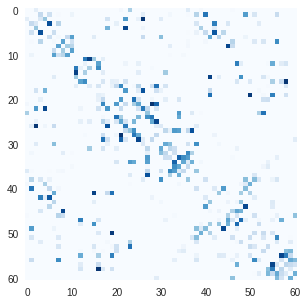

In [11]:
mtx = get_mtx(mrf)  
plot_mtx(mtx)

## Look at top co-evolving residue pairs

In [12]:
# load mtx into pandas dataframe
pd_mtx = pd.DataFrame(mtx,columns=["i","j","zscore"])

# get contacts with sequence seperation > 5
# sort by zscore, show top 10
top = pd_mtx.loc[pd_mtx['j'] - pd_mtx['i'] > 5].sort_values("zscore",ascending=False)
top.head(10)

,i,j,zscore
1056,21,28,2.974240
881,16,58,2.959056
142,2,26,2.940567
999,19,50,2.919788
820,15,41,2.856995
488,8,45,2.819356
251,4,22,2.814179
1278,27,37,2.747134
934,18,26,2.730285
326,5,42,2.690712


## Explore the MRF

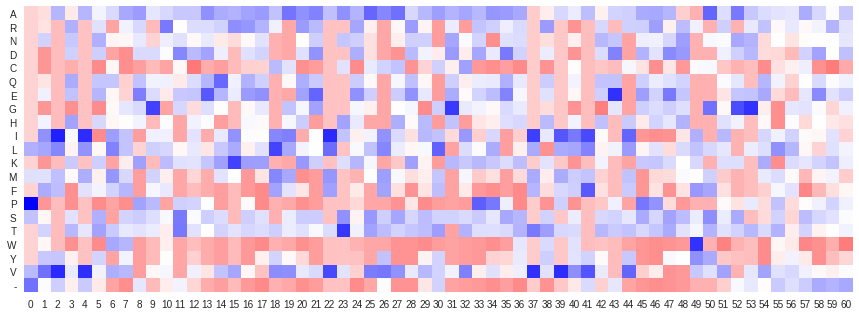

In [13]:
def plot_v(mrf):  
  al_a = list(alphabet)
  v = mrf["v"].T
  mx = np.max((v.max(),np.abs(v.min())))
  plt.figure(figsize=(v.shape[1]/4,states/4))
  plt.imshow(-v,cmap='bwr',vmin=-mx,vmax=mx)
  plt.xticks(np.arange(v.shape[1]))
  plt.yticks(np.arange(0,21))
  plt.grid(False)
  ax = plt.gca()
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: mrf["v_idx"][x])) 
  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x]))
  
plot_v(mrf)

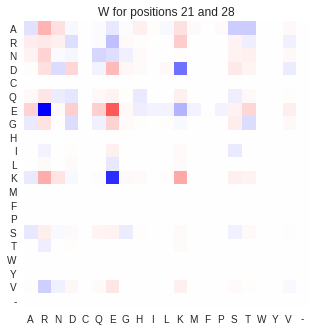

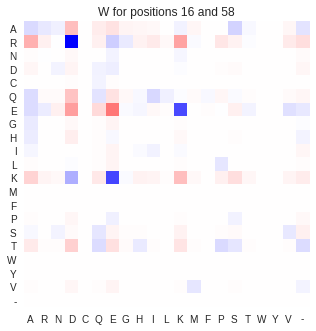

In [14]:
def plot_w(mrf,i,j):
  
  n = int(np.where((mrf["w_idx"][:,0] == i)&(mrf["w_idx"][:,1] == j))[0])
  w = mrf["w"][n]
  
  mx = np.max((w.max(),np.abs(w.min())))
  plt.figure(figsize=(states/4,states/4))
  plt.imshow(-w,cmap='bwr',vmin=-mx,vmax=mx)
  plt.xticks(np.arange(0,states))
  plt.yticks(np.arange(0,states))
  plt.grid(False)
  
  ax = plt.gca()
  al_a = list(alphabet)
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x])) 
  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x]))
  plt.title(f"W for positions {i} and {j}")
  plt.show()

for n in range(2):
  i = int(top.iloc[n]["i"])
  j = int(top.iloc[n]["j"])
  plot_w(mrf,i,j)

## validating output
(comparing to known output from GREMLIN_cpp version)

In [0]:
!wget -q -nc http://files.ipd.uw.edu/krypton/4FAZA.out

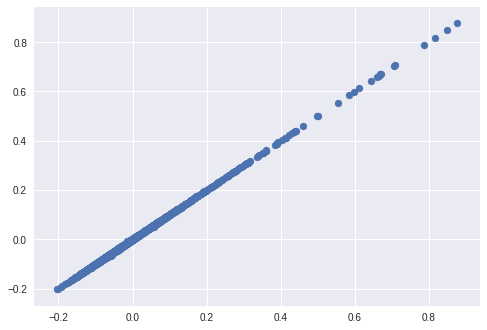

In [16]:
pd_test = pd.read_table("4FAZA.out",sep=" ")
plt.scatter(pd_test["apc"],mtx["apc"])
plt.show()

## Useful input features for NN (Neural Networks)

The "apc" values are typically used as input to the NN for contact cleaning or structure prediction. Though in recent advances (aka DeepMind/Alphafold), the entire MRF was used as the input. More specificially LxLx442. The 442 channels are the 21x21 + (raw and/or apc) value.

In [17]:
w_out = np.zeros((mrf["length_ori"],mrf["length_ori"],442))
v_out = np.zeros((mrf["length_ori"],21))

mrf_ = np.reshape(mrf["w"],(-1,441))
mtx_ = np.expand_dims(mtx["apc"],-1)

w_out[(mtx["i"],mtx["j"])] = np.concatenate((mrf_,mtx_),-1)
w_out += np.transpose(w_out,(1,0,2))
v_out[mrf["v_idx"]] = mrf["v"]

print("w_out",w_out.shape)
print("v_out",v_out.shape)

w_out (62, 62, 442)
v_out (62, 21)


## GREMLIN_simple
Sometimes it's useful to have a stripped down version of the algorithm/model, for purposes of understanding! 

### For CS folks
GREMLIN is technically an "autoencoder" with single dense layer and NO latent/hidden variables. The goal is to encode/decode a sequence of letters (21 categories)

* loss = categoricalcrossentropy(msa,softmax(dense(msa,w,b)) + l2_loss(v) + l2_loss(w)
 -  aka PLL (pseudolikelihood)
* msa = input dataset
 - aka multiple sequence alignment
 - msa.shape = (batch, L x 21)
 - 21 =  (20 amino acids + 1 gap) categories
* w = weight
 -  aka W (2-body-term), aka co-evolution
 - W.shape = (L x 21, L x 21)
* b = bias 
 - aka V (1-body-term), aka conservation
 - V.shape = (L x 21)

In [0]:
def GREMLIN_simple(msa, opt_iter=200, opt_rate=0.1, batch_size=None):
  
  # kill any existing tensorflow graph
  tf.reset_default_graph()
  
  length = msa["length"] # length of sequence
  
  # setting up weights
  b = tf.get_variable("b",
                      shape=(length*states),
                      initializer=tf.initializers.zeros)

  w_tmp = tf.get_variable(name="w",
                          shape=[length,states,length,states],
                          initializer=tf.initializers.zeros)
  
  # set diagional to zero, make symmetric
  w = w_tmp * np.reshape(1-np.eye(length),(length,1,length,1)) 
  w = w + tf.transpose(w,[2,3,0,1])
  w = tf.reshape(w,(length*states,length*states))
  
  # input
  MSA = tf.placeholder(tf.int32,shape=(None,length),name="msa")
  MSA_weights = tf.placeholder(tf.float32, shape=(None,), name="msa_weights")
  OH_MSA = tf.one_hot(MSA,states,dtype=tf.float32)
  IN = tf.reshape(OH_MSA,(-1,length*states))
  
  # dense layer + softmax activation
  O = tf.tensordot(IN,w,1) + b
  O = tf.nn.softmax(tf.reshape(O,(-1,length,states)),-1)

  # loss = categorical crossentropy (aka pseudo-likelihood)
  loss = tf.reduce_sum(tf.keras.losses.categorical_crossentropy(OH_MSA,O),-1)
  loss = tf.reduce_sum(loss*MSA_weights)
  
  if batch_size is not None:
    loss = loss*(msa["neff"]/tf.reduce_sum(MSA_weights))
  
  # add L2 regularization
  l2_b = 0.01*tf.reduce_sum(tf.square(b))
  l2_w = 0.01*tf.reduce_sum(tf.square(w))*0.5*(length-1)*(states-1)
  loss = loss + l2_b + l2_w
  
  # setup optimizer
  opt_b = tf.train.AdamOptimizer(opt_rate).minimize(loss,var_list=[b])
  learning_rate = opt_rate * np.log(msa["neff"])/msa["length"]
  opt_bw = tf.train.AdamOptimizer(learning_rate).minimize(loss,var_list=[b,w_tmp])
  
  # input to placeholders
  feed = {MSA:msa["msa"],MSA_weights:msa["msa_weights"]}
  
  with tf.Session() as sess:
    # initialize
    sess.run(tf.global_variables_initializer())
    for opt in (opt_b,opt_bw):
      for i in range(opt_iter):
        if batch_size is None: sess.run(opt,feed)
        else:
          idx = np.random.randint(0,msa["num"],size=batch_size)
          sess.run(opt,{MSA:msa["msa"][idx], MSA_weights:msa["msa_weights"][idx]})

        if (i+1)%int(opt_iter/10) == 0: print((i+1),sess.run(loss,feed))
 
    # save the b and w (aka V and W parameters of the MRF)
    V_ = np.reshape(sess.run(b),(length,states))
    W_ = np.reshape(sess.run(w),(length,states,length,states))
    
  # only return upper-right triangle of matrix (since it's symmetric)
  tri = np.triu_indices(length,1)
  W_ = W_[tri[0],:,tri[1],:]
  
  mrf = {"v": V_,
         "w": W_,
         "v_idx": msa["v_idx"],
         "w_idx": msa["w_idx"],
         "length_ori": msa["length_ori"]}
  return mrf

In [19]:
%%time
mrf_simple = GREMLIN_simple(msa)
mtx_simple = get_mtx(mrf_simple)

20 53554.016
40 51086.117
60 50769.73
80 50670.285
100 50621.965
120 50591.81
140 50570.582
160 50554.945
180 50543.117
200 50533.98
20 27732.219
40 26758.094
60 26609.0
80 26572.695
100 26558.176
120 26549.543
140 26543.79
160 26539.77
180 26536.883
200 26535.54
CPU times: user 3.15 s, sys: 726 ms, total: 3.87 s
Wall time: 3.88 s


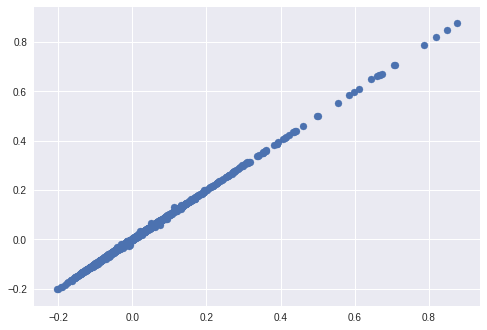

In [20]:
plt.scatter(mtx["apc"],mtx_simple["apc"])
plt.show()